In [1]:
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pylab
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pycocotools.coco import COCO
from pycocotools import mask
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# COCO Dataset

Prerequisites: 
- download COCO dataset off of website: https://cocodataset.org/#download
- install COCO API via `conda install -c conda-forge pycocotools`

In [2]:
class CocoDataset(Dataset):
    """
    Torch Dataset style implementation for COCO dataset. Requires pycocotools APIs.
    Use `conda install -c conda-forge pycocotools` to install.
    """
    
    def __init__(self, data_dir, dataset, anno_type, imgIds=[], catIds=[], transforms=None):
        """
        Initializes the pycocotools API as `self.coco`.
        Params:
        `data_dir`  : COCO style dataset directory
        `dataset`   : label of dataset (i.e. train/valid/test)
        `anno_type` : type of task (i.e. captions, instances, panoptic, person_keypoints, stuff)
        `imgIds`    : list of image IDs to select; defaults is empty list to load all images
        `catIds`    : list of category IDs to select; default is empty list to load all categories
        `transforms`: list of transforms to apply on each sample drawn from the dataset; defaults to None
        """
        self.dataset   = dataset
        self.img_dir   = f"{data_dir}/{dataset}"
        self.anno_file = f"{data_dir}/annotations/{anno_type}_{dataset}.json"
        self.coco = COCO(self.anno_file)
        self.imgIds    = imgIds
        self.catIds    = catIds
        self.transforms= transforms
        imgIds = self.coco.getImgIds(imgIds=imgIds, catIds=catIds)
        imgIds = list(sorted(imgIds))
        self.imgs = self.coco.loadImgs(imgIds)
        # get all categories
        allCatIds = self.coco.getCatIds()
        self.allcats = self.coco.loadCats(allCatIds)
        # make cat->id and id->cat lookup dicts
        self.id2cat = {cat['id']: cat['name'] for cat in self.allcats}
        self.cat2id = {cat['name']: cat['id'] for cat in self.allcats}
        
    
    def __repr__(self):
        return f"COCO {self.dataset}; annoFile: {self.anno_file}; imgIds={self.imgIds}; catIds={self.catIds}"

    
    def __len__(self):
        return len(self.imgs)
        
        
    def __getitem__(self, idx):
        # load image using PIL for better integration with native torch transforms
        img = Image.open(f"{self.img_dir}/{self.imgs[idx]['file_name']}")
        # load annotations associated with the image
        annIds = self.coco.getAnnIds(imgIds=self.imgs[idx]['id'])
        annotations = self.coco.loadAnns(annIds)
        # parse annotations
        segmaps  = list()
        cats     = list()
        boxes    = list()
        for anno in annotations:
            if anno['iscrowd']==0:
                segmaps.append(anno['segmentation'])
                cats.append(anno['category_id'])
                boxes.append(anno['bbox'])
        sample = {'image': img, # PILImage
                  'segs' : segmaps, # list of INT of length N
                  'cats' : np.stack(cats, axis=0)  if len(cats)>0  else np.stack([0], axis=0), # [N, 1]
                  'boxes': np.stack(boxes, axis=0) if len(boxes)>0 else np.stack([[0,0,0,0]], axis=0), # [N,4]
                 }
        if self.transforms:
            sample = self.transforms(sample)
        return sample


    @classmethod
    def collate_fn(cls, batch, img_resized=False):
        """
        custom collate function (to be passed to the DataLoader) for combining tensors of 
        different sizes into lists.
        """
        images = list()
        segs   = list()
        cats   = list()
        boxes  = list()
        for sample in batch:
            images.append(sample['image'].unsqueeze(0))
            segs.append(sample['segs'])
            cats.append(sample['cats'])
            boxes.append(sample['boxes'])
        
        # if images have already been resized to same shape, then combine them into a 
        # single 4-D tensor of (B, C, H, W)
        if img_resized:
            images = torch.cat(images, 0)
                    
        batch = {'images': images,
                 'segs': segs,
                 'cats': cats,
                 'boxes': boxes
                }
        return batch

Instantiate a `CocoDataset` class object based on the *train2017* dataset

In [3]:
ds = CocoDataset(data_dir='./', dataset='val2017', anno_type='instances')

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


Test retrieving any index item from dataset

(-0.5, 639.5, 425.5, -0.5)

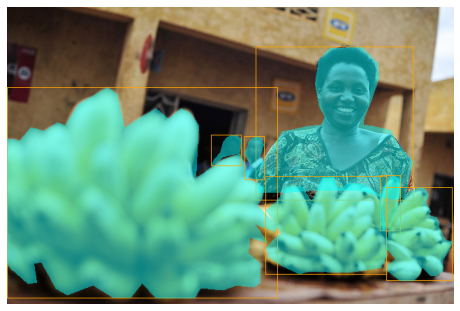

In [4]:
# retrieve random sample
sample = ds[90]

# visualize the sample
img  = sample['image']
draw = ImageDraw.Draw(img, 'RGBA')

for i in range(sample['boxes'].shape[0]):
    # go through all boxes & draw
    # bbox coordinates are provides in terms of [x,y,width,height], and
    # box coordinates are measured from the top left image corner and are 0-indexed
    box = list(sample['boxes'][i,:])
    x0, y0 = box[0], box[1]
    x1, y1 = x0+box[2], y0+box[3]
    draw.rectangle([x0,y0,x1,y1], outline='orange')
    # go through all segmaps & draw
    segmap = sample['segs'][i][0]
    draw.polygon(segmap, fill=(0, 255, 255, 125))
plt.imshow(img); plt.axis('off')


# COCO Transformations

In order to collate multiple images into a single batch, each image will need to be resized into the same shape of N-by-N (since most CNN models take in a square image patch). Correspondingly, the bounding boxes and segmentation maps all have to be adjusted in size & location accordingly.

In [5]:
class ImageToTensor(object):
    """
    Provides encode/decode methods to transform PILimage to tensor and vice-versa.
    The forward call of the class method assumes the input is of type `dict` with 'image'
    as one of its keys that holds a corresponding value that is a PILimage, and performs
    `encode` on the image.
    """
    def __init__(self):
        self.encoder = transforms.ToTensor()
        self.decoder = transforms.ToPILImage()
        
    def __call__(self, sample):
        sample['image'] = self.encode(sample['image'])
        return sample

    def encode(self, img):
        return self.encoder(img)
    
    def decode(self, tensor):
        return self.decoder(tensor)

In [6]:
class CategoryToTensor(object):
    """
    Provides encodes/decodes methods to transform category classes from 
    np.array format to torch.tensor format and vice-versa. 
    The forward call of the class method assumes the input is of type `dict`
    with 'cats' as one of its keys that holds a corresponding value that is 
    a np.array, and performs `encode` on the numpy array.
    """        
    def __call__(self, sample):
        sample['cats'] = self.encode(sample['cats'])
        return sample

    def encode(self, cats):
        return torch.LongTensor(cats)
    
    def decode(self, tensor):
        return tensor.numpy()

In [7]:
class BoxToTensor(object):
    """
    Provides encodes/decodes methods to transform bounding boxes from 
    np.array format to torch.tensor format and vice-versa. 
    The forward call of the class method assumes the input is of type `dict`
    with 'boxes' as one of its keys that holds a corresponding value that is 
    a np.array, and performs `encode` on the numpy array.
    """       
    def __call__(self, sample):
        sample['boxes'] = self.encode(sample['boxes'])
        return sample

    def encode(self, boxes):
        return torch.FloatTensor(boxes)
    
    def decode(self, tensor):
        return tensor.numpy()

In [12]:
# Basic transforms
basic_tfs = [ImageToTensor(), CategoryToTensor(), BoxToTensor()]

# compose the list of transforms to apply to each sample
tfms = transforms.Compose(basic_tfs)
# create dataset
ds = CocoDataset(data_dir='./', dataset='val2017', anno_type='instances', transforms=tfms)
# create dataloader
BS = 8
dl = DataLoader(ds, batch_size=BS, shuffle=True, collate_fn=ds.collate_fn)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [13]:
# get a single batch from dataloader
batch = next(iter(dl))
print(f"{len(batch['images'])} images in batch\n")
for i in range(len(batch['images'])):
    print(f"image {i}:\n\tsize:  {batch['images'][i].shape}")
    print(f"\t# of objects in scene: {len(batch['boxes'][i])}")
    print(f"\tcats:  {batch['cats'][i].shape}")
    print(f"\tboxes: {batch['boxes'][i].shape}")

8 images in batch

image 0:
	size:  torch.Size([1, 3, 370, 640])
	# of objects in scene: 18
	cats:  torch.Size([18])
	boxes: torch.Size([18, 4])
image 1:
	size:  torch.Size([1, 3, 428, 640])
	# of objects in scene: 8
	cats:  torch.Size([8])
	boxes: torch.Size([8, 4])
image 2:
	size:  torch.Size([1, 3, 428, 640])
	# of objects in scene: 3
	cats:  torch.Size([3])
	boxes: torch.Size([3, 4])
image 3:
	size:  torch.Size([1, 3, 500, 332])
	# of objects in scene: 3
	cats:  torch.Size([3])
	boxes: torch.Size([3, 4])
image 4:
	size:  torch.Size([1, 3, 375, 500])
	# of objects in scene: 7
	cats:  torch.Size([7])
	boxes: torch.Size([7, 4])
image 5:
	size:  torch.Size([1, 3, 424, 640])
	# of objects in scene: 7
	cats:  torch.Size([7])
	boxes: torch.Size([7, 4])
image 6:
	size:  torch.Size([1, 3, 426, 640])
	# of objects in scene: 2
	cats:  torch.Size([2])
	boxes: torch.Size([2, 4])
image 7:
	size:  torch.Size([1, 3, 480, 640])
	# of objects in scene: 6
	cats:  torch.Size([6])
	boxes: torch.Size([6